In [1]:
# 导入相关地依赖库
import matplotlib.pyplot as  plt
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os,cv2,random,zipfile,fitz,re,shutil,time
import numpy as np
from tqdm import tqdm  # 显示进度条
import pandas as pd
from sklearn.model_selection import train_test_split
tf.__version__

'2.3.0'

In [2]:
# 读入数据

EXCEL_Data1="C:/Users/ASUS/Desktop/problem c/2021_MCM_Problem_C_Data/2021MCMProblemC_DataSet.xlsx"
EXCEL_Data2="./2021_MCM_Problem_C_Data/2021MCM_ProblemC_ Images_by_GlobalID.xlsx"
AllDataOfExcel1=pd.read_excel(EXCEL_Data1,engine='openpyxl')#用openpyxl代替xlrd，不然不支持xlsx文件
AllDataOfExcel2=pd.read_excel(EXCEL_Data2,engine='openpyxl')#用openpyxl代替xlrd，不然不支持xlsx文件

In [3]:
# 把两个表格中的数据融合在一起
da=AllDataOfExcel1[['GlobalID','Lab Status','Latitude','Longitude']]#在数据中选取感兴趣的数据
mylist=AllDataOfExcel2['GlobalID'].values.tolist()#转化成列表

length=len(da['GlobalID'])
temp=[0]*length
for i in range(length):
    if da.loc[i,'GlobalID'] in mylist:#指定某一列中查找
        temp[i]=AllDataOfExcel2.loc[mylist.index(da.loc[i,'GlobalID']),'FileName']
# 增加图片文件信息
da['FileName']=temp


In [4]:
# 把处理好的数据保存下来
writer=pd.ExcelWriter('C:/Users/ASUS/Desktop/problem c/mydata.xlsx')
da.to_excel(writer)
writer.save()

In [5]:
# 得到有照片对应的数据
DataOfName=[]
DataOfLab=[]
mylist=[]
mylist=da['FileName'].values.tolist()#转化成列表
for i in range(len(mylist)):
    # 如果有视频对应
    if mylist[i]:
        # 如果是判断了的标签
        if da.loc[i,'Lab Status'] in ['Positive ID', 'Negative ID']:
            DataOfName.append(mylist[i])#取得文件名
            DataOfLab.append(da.loc[i,'Lab Status'])#取得标签
mydata2=pd.DataFrame([DataOfName,DataOfLab])
mydata2=mydata2.T
mydata2.columns=['FileName','Lab Status']
# 把处理好的数据保存下来
writer=pd.ExcelWriter('C:/Users/ASUS/Desktop/problem c/mydata3.xlsx')
mydata2.to_excel(writer)
writer.save()

In [6]:
#定义数据集的大小、路劲等参数
NUM_CLASSES = 2
BATCH_SIZE = 64
Lab_Data_Path = "./2021_MCM_Problem_C_Data"
Img_Data_Path = "./2021MCM_ProblemC_Files"

EXCEL_Data1="./2021_MCM_Problem_C_Data/2021MCMProblemC_DataSet.xlsx"
EXCEL_Data2="./2021_MCM_Problem_C_Data/2021MCM_ProblemC_ Images_by_GlobalID.xlsx"

CATEGORIES = ['Positive ID', 'Negative ID']
image_size = 64
EPOCH=80
NUM_EPOCH=2

In [7]:
#数据提取函数，把图片、标签分开，并且把两种预测结果分开
def create_data(DIR,DataOfName):
    #创建数据集，兼容五种格式
    data=[]
    Positive_img_data=[]
    Positive_lab_data=[]
    Negative_img_data=[]
    Negative_lab_data=[]
    for i in range(len(DataOfName)):
        FileName=DataOfName[i]
        path=os.path.join(DIR,FileName)
        #如果是图片
        if ('png' in FileName or 'jpg'in FileName or 'jfif'in FileName):
            create_data_from_img(path,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,DataOfLab[i])
        elif ('pdf'in FileName):
            create_data_from_pdf(path,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,DataOfLab[i])
        elif('docx'in FileName):
            create_data_from_docx(path,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,DataOfLab[i])
        elif('MOV'in FileName or 'mp4'in FileName):
            create_data_from_video(path,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,DataOfLab[i])
        elif('zip'in FileName):
            create_data_from_zip(path,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,DataOfLab[i])
    
    return Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data

def append_data(Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,new_array,class_num):
    if class_num==0:
        Positive_img_data.append(new_array)
        Positive_lab_data.append(class_num)
    elif class_num==1:
        Negative_img_data.append(new_array)
        Negative_lab_data.append(class_num)

def create_data_from_img(DIR,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,category):
    #如果数据是图片，png、jpg、jfif
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    img_array= cv2.imread(DIR) #读取照片
    new_array= cv2.resize(img_array,(image_size,image_size))#转化大小

    append_data(Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,new_array,class_num)
    
    
def create_data_from_pdf(DIR,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,category):
    # 在PDF中提取照片信息
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    pic_path = DIR[0:len(DIR)-4] #解压后的路径
    # 创建保存图片的文件夹，如果已经存在则不创建
    if os.path.exists(pic_path):
        pass
    else:
        os.mkdir(pic_path)

    t0 = time.clock()                          # 生成图片初始时间
    checkXO = r"/Type(?= */XObject)"           # 使用正则表达式来查找图片
    checkIM = r"/Subtype(?= */Image)"
    doc = fitz.open(DIR)                      # 打开pdf文件
    imgcount = 0                               # 图片计数
    lenXREF = doc._getXrefLength()             # 获取对象数量长度
     

    # 遍历每一个对象
    for i in range(1, lenXREF):
        text = doc._getXrefString(i)            # 定义对象字符串
        isXObject = re.search(checkXO, text)    # 使用正则表达式查看是否是对象
        isImage = re.search(checkIM, text)      # 使用正则表达式查看是否是图片
        if not isXObject or not isImage:        # 如果不是对象也不是图片，则continue
            continue
        imgcount += 1

        pix = fitz.Pixmap(doc, i)               # 生成图像对象
        new_name = "Img{}.png".format(imgcount) # 生成图片的名称
        if pix.n < 5:                           # 如果pix.n<5,可以直接存为PNG
            pix.writePNG(os.path.join(pic_path, new_name))
        else:                                   # 否则先转换CMYK
            pix0 = fitz.Pixmap(fitz.csRGB, pix)
            pix0.writePNG(os.path.join(pic_path, new_name))
            pix0 = None
        pix = None                              # 释放资源
        t1 = time.clock()                       # 图片完成时间
        print("run:{}s".format(t1 - t0))
        print("Total take {} imges".format(imgcount))

        # 进到文件夹里边读取图像数据
        img_array= cv2.imread(os.path.join(pic_path, new_name)) #读取照片
        new_array= cv2.resize(img_array,(image_size,image_size))#转化大小

        append_data(Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,new_array,class_num)
        

    

def create_data_from_docx(DIR,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,category):
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    path=DIR
    zip_path=DIR[0:len(DIR)-4]+'zip'
    tmp_path=DIR[0:len(DIR)-5]+'temp'
    store_path=DIR[0:len(DIR)-5]

    # 创建保存图片的文件夹，如果已经存在则不创建
    if os.path.exists(tmp_path):
        pass
    else:
        os.mkdir(tmp_path)
    if os.path.exists(store_path):
        pass
    else:
        os.mkdir(store_path)
    
    # 将docx文件重命名为zip文件
    os.rename(path, zip_path)
    f = zipfile.ZipFile(zip_path, 'r')# 进行解压
    for file in f.namelist():# 将图片提取并保存
        f.extract(file, tmp_path)
    f.close()# 释放该zip文件

    # 将docx文件从zip还原为docx
    os.rename(zip_path, path)
    # 得到缓存文件夹中图片列表
    pic = os.listdir(os.path.join(tmp_path, 'word/media'))

    # 将图片复制到最终的文件夹中
    for i in pic:
        # 根据word的路径生成图片的名称
        new_name = path.replace('\\', '_')
        new_name = new_name.replace(':', '') + '_' + i
        shutil.copy(os.path.join(tmp_path + '/word/media', i), os.path.join(store_path, new_name))

        # 读取数据
        img_array= cv2.imread(os.path.join(store_path, new_name)) #读取照片
        new_array= cv2.resize(img_array,(image_size,image_size))#转化大小

        append_data(Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,new_array,class_num)

    # 删除缓冲文件夹中的文件，用以存储下一次的文件
    for i in os.listdir(tmp_path):
        # 如果是文件夹则删除
        if os.path.isdir(os.path.join(tmp_path, i)):
            shutil.rmtree(os.path.join(tmp_path, i))


def create_data_from_video(DIR,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,category):
    # 从视频中读取数据，一帧一帧读取
    cap = cv2.VideoCapture(DIR)#打开视频
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    count=0
    count_max=24-1
    while cap.isOpened():#如果成功打开
        rval, image = cap.read()
        if rval==True:
            if count==count_max:
                new_array = cv2.resize(image, (image_size, image_size))  
                append_data(Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,new_array,class_num)
                count=0
            else:
                count+=1
        else:
            break
    
    
def create_data_from_zip(DIR,Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,category):
    #从压缩包中得到数据
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    with zipfile.ZipFile(DIR, mode='r') as zfile: # 只读方式打开压缩包
 
        for name in zfile.namelist():  # 获取zip文档内所有文件的名称列表
            if ('.jpg' not in name) or ('.JPG'not in name):# 仅读取.jpg图片，过滤掉文件夹，及其他非.jpg后缀文件
                continue
            #print(name)
            with zfile.open(name,mode='r') as image_file:
                content = image_file.read() # 一次性读入整张图片信息
                image = np.asarray(bytearray(content), dtype='uint8')
                new_array = cv2.resize(image, (image_size, image_size))  
                
                append_data(Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data,new_array,class_num)

    zfile.close()

In [8]:
#得到全部的数据
Positive_img_data,Positive_lab_data,Negative_img_data,Negative_lab_data=create_data(Img_Data_Path,DataOfName)

X_Train_Positive,X_Test_Positive,Y_Train_Positive,Y_Test_Positive=train_test_split(Positive_img_data,Positive_lab_data,test_size=0.25)
X_Train_Negative,X_Test_Negative,Y_Train_Negative,Y_Test_Negative=train_test_split(Negative_img_data,Negative_lab_data,test_size=0.25)

X_train=X_Train_Positive+X_Train_Negative
Y_train=Y_Train_Positive+Y_Train_Negative
X_test =X_Test_Positive+X_Test_Negative
Y_test =Y_Test_Positive+Y_Test_Negative



run:4.5956058s
Total take 1 imges
run:0.5238272999999989s
Total take 1 imges
run:0.8786720999999993s
Total take 1 imges
run:1.6405384000000005s
Total take 2 imges
run:2.632955199999998s
Total take 3 imges
run:3.4345084999999997s
Total take 4 imges
run:4.4241885s
Total take 5 imges
run:5.183836199999998s
Total take 6 imges


In [14]:
TrainData=[]
TestData=[]
for i in range(len(X_train)):
    TrainData.append([X_train[i],Y_train[i]])
for i in range(len(X_test)):
    TestData.append([X_test[i],Y_test[i]])
    
# 对数据进行随机打乱顺序
random.shuffle(TrainData)
random.shuffle(TestData)


In [16]:
# 把数据预处理打包成函数，想放到训练的时候每一次都调用一次，增强数据

def TrainData_process(data):
    # 对训练数据进行数据增强、预处理
    X = []
    Y = []

    for features,label in data:
        X.append(features)
        Y.append(label)

    X = np.array(X).reshape(-1, image_size, image_size, 3)
    Y = np.array(Y)
    
    # 针对训练数据集的预处理，数据增强，减少过拟合
    train_image_generator = ImageDataGenerator(
        rescale=1./255,         # 此值将在执行前成到整个图像上，把数值归一化
        rotation_range=45,      # 随机进行转动的角度
        horizontal_flip=True,   # 是否进行随机水平翻转
        vertical_flip=True,     # 是否随机竖直翻转
        width_shift_range=0.1,  # 随机水平偏移的幅度
        height_shift_range=0.1, # 随机竖直偏移的幅度
        zoom_range=0.5          # 随机进行放大的幅度，浮点数或者[low，hight]
        )
    train_data_gen = train_image_generator.flow(X, Y, batch_size = BATCH_SIZE)  # 抽取batch_size数量的数据组合为一个batch
    # print()
    # print("===调用1次===")
    # print()
    return train_data_gen


def TestData_process(data):
    # 对测试数据预处理
    X = []
    Y = []

    for features,label in data:
        X.append(features)
        Y.append(label)

    X = np.array(X).reshape(-1, image_size, image_size, 3)
    Y = np.array(Y)    
    # 针对验证数据集，不需数据增强
    validation_image_generator = ImageDataGenerator(rescale=1./255)
    val_data_gen = validation_image_generator.flow(X, Y, batch_size = BATCH_SIZE) # 抽取batch_size数量的数据组合为一个batch
    return val_data_gen

# 预处理后的数据
TrainData = TrainData_process(TrainData)
TestData = TestData_process(TestData)

In [22]:
TotalOfTrain=len(X_train)
TotalOfTest=len(X_test)
print(TotalOfTrain)
print(TotalOfTest)

2212
738


In [17]:
def PlotOfModel2(history):
    # 可视化模型的准确度和损失率
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()  

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
34/34 [==============================] - ETA: 0s - loss: 0.0860 - acc: 0.9898
Epoch 00001: val_loss improved from inf to 0.18488, saving model to model03_01_0.18.h5
34/34 [==============================] - 9s 276ms/step - loss: 0.0860 - acc: 0.9898 - val_loss: 0.1849 - val_acc: 0.9957
Epoch 2/80
34/34 [==============================] - ETA: 0s - loss: 0.0350 - acc: 0.9967
Epoch 00002: val_loss improved from 0.18488 to 0.07305, saving model to model03_02_0.07.h5
34/34 [==============================] - 9s 266ms/step - loss: 0.0350 - acc: 0.9967 - val_loss: 0.0731 - val_acc: 0.9957
Epoch 3/80
34/34 [==============================] - ETA: 0s - loss: 0.0253 - acc: 0.9963
Epoch 00003: val_loss did not improve from 0.07305
34/34 [==============================] - 9s 274ms/step - loss: 0.0253 - acc: 0.9963 - val_loss: 0.1488 - val_acc: 0.9957
Epoch 4/80
34/34 [==============================] - ETA: 0s - los

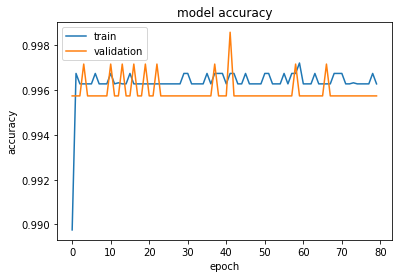

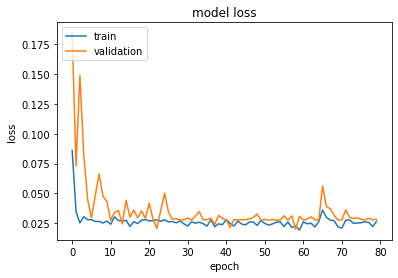

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 28, 32)        3104      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 32)        3104      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 32)       

In [23]:
BATCH_SIZE=64
# 搭建卷积神经网络
model = Sequential()

# 第一层卷积，16个3*3的卷积核
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(image_size,image_size,3)))
model.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))
model.add(Dropout(0.25))       # 随机丢弃

# 第二层卷积
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 1), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(1, 3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))
model.add(Dropout(0.5))


# 拉伸层，在全连接层前得进行拉伸操作
model.add(Flatten())

# 全连接层
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))


# 进行模型设置
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#  设置生成器得参数
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model03_{epoch:02d}_{val_loss:.2f}.h5', # 模型保存地址，默认保存整个模型save_weights_only=False
        save_best_only=True,         # 只保存在验证集上性能最好的模型
        monitor='val_loss',          # 设置被检测的数据val_acc或者val_loss，测试集的准确率和损失率
        verbose=1                    # 1打印详细信息
    )
]

# 利用python的生成器，这个生成数据的batch并经行训练
# 一个 History 对象。其 History.history 属性是连续 epoch 训练损失和评估值，以及验证集损失和评估值的记录（如果适用）
history = model.fit_generator(
    # train_data_gen,                             # 生成器函数，输出为（inputs,targets)
    # TrainData_process(training_data),             # 每次都进行数据增强
    TrainData,
    steps_per_epoch=TotalOfTrain // BATCH_SIZE,    # 当生成器返回steps_per_epoch次数据时计一个epoch结束，执行下一个epoch
    epochs= EPOCH,                                   # 数据迭代的轮数
    validation_data=TestData,                 # 生成验证集的生成器
    validation_steps=TotalOfTest // BATCH_SIZE,     # 指定验证集生成器返回次数
    callbacks = callbacks                         # 在训练时调用的一系列回调函数
)

PlotOfModel2(history)
model.summary()

In [12]:
def create_data(DIR):
    #创建数据集，兼容五种格式
    data=[]
    for i in range(len(DataOfName)):
        FileName=DataOfName[i]
        path=os.path.join(DIR,FileName)
        #如果是图片
        if ('png' in FileName or 'jpg'in FileName or 'jfif'in FileName):
            create_data_from_img(path,data,DataOfLab[i])
        elif ('pdf'in FileName):
            create_data_from_pdf(path,data,DataOfLab[i])
        elif('docx'in FileName):
            create_data_from_docx(path,data,DataOfLab[i])
        elif('MOV'in FileName or 'mp4'in FileName):
            create_data_from_video(path,data,DataOfLab[i])
        elif('zip'in FileName):
            create_data_from_zip(path,data,DataOfLab[i])
    return data

def create_data_from_img(DIR,data,category):
    #如果数据是图片，png、jpg、jfif
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    img_array= cv2.imread(DIR) #读取照片
    new_array= cv2.resize(img_array,(image_size,image_size))#转化大小
    data.append([new_array,class_num])#进行数据组合
    
    
def create_data_from_pdf(DIR,data,category):
    # 在PDF中提取照片信息
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    pic_path = DIR[0:len(DIR)-4] #解压后的路径
    # 创建保存图片的文件夹，如果已经存在则不创建
    if os.path.exists(pic_path):
        pass
    else:
        os.mkdir(pic_path)

    t0 = time.clock()                          # 生成图片初始时间
    checkXO = r"/Type(?= */XObject)"           # 使用正则表达式来查找图片
    checkIM = r"/Subtype(?= */Image)"
    doc = fitz.open(DIR)                      # 打开pdf文件
    imgcount = 0                               # 图片计数
    lenXREF = doc._getXrefLength()             # 获取对象数量长度
     

    # 遍历每一个对象
    for i in range(1, lenXREF):
        text = doc._getXrefString(i)            # 定义对象字符串
        isXObject = re.search(checkXO, text)    # 使用正则表达式查看是否是对象
        isImage = re.search(checkIM, text)      # 使用正则表达式查看是否是图片
        if not isXObject or not isImage:        # 如果不是对象也不是图片，则continue
            continue
        imgcount += 1

        pix = fitz.Pixmap(doc, i)               # 生成图像对象
        new_name = "Img{}.png".format(imgcount) # 生成图片的名称
        if pix.n < 5:                           # 如果pix.n<5,可以直接存为PNG
            pix.writePNG(os.path.join(pic_path, new_name))
        else:                                   # 否则先转换CMYK
            pix0 = fitz.Pixmap(fitz.csRGB, pix)
            pix0.writePNG(os.path.join(pic_path, new_name))
            pix0 = None
        pix = None                              # 释放资源
        t1 = time.clock()                       # 图片完成时间
        print("run:{}s".format(t1 - t0))
        print("Total take {} imges".format(imgcount))

        # 进到文件夹里边读取图像数据
        img_array= cv2.imread(os.path.join(pic_path, new_name)) #读取照片
        new_array= cv2.resize(img_array,(image_size,image_size))#转化大小
        data.append([new_array,class_num])#进行数据组合

    

def create_data_from_docx(DIR,data,category):
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    path=DIR
    zip_path=DIR[0:len(DIR)-4]+'zip'
    tmp_path=DIR[0:len(DIR)-5]+'temp'
    store_path=DIR[0:len(DIR)-5]

    # 创建保存图片的文件夹，如果已经存在则不创建
    if os.path.exists(tmp_path):
        pass
    else:
        os.mkdir(tmp_path)
    if os.path.exists(store_path):
        pass
    else:
        os.mkdir(store_path)
    
    # 将docx文件重命名为zip文件
    os.rename(path, zip_path)
    f = zipfile.ZipFile(zip_path, 'r')# 进行解压
    for file in f.namelist():# 将图片提取并保存
        f.extract(file, tmp_path)
    f.close()# 释放该zip文件

    # 将docx文件从zip还原为docx
    os.rename(zip_path, path)
    # 得到缓存文件夹中图片列表
    pic = os.listdir(os.path.join(tmp_path, 'word/media'))

    # 将图片复制到最终的文件夹中
    for i in pic:
        # 根据word的路径生成图片的名称
        new_name = path.replace('\\', '_')
        new_name = new_name.replace(':', '') + '_' + i
        shutil.copy(os.path.join(tmp_path + '/word/media', i), os.path.join(store_path, new_name))

        # 读取数据
        img_array= cv2.imread(os.path.join(store_path, new_name)) #读取照片
        new_array= cv2.resize(img_array,(image_size,image_size))#转化大小
        data.append([new_array,class_num])#进行数据组合

    # 删除缓冲文件夹中的文件，用以存储下一次的文件
    for i in os.listdir(tmp_path):
        # 如果是文件夹则删除
        if os.path.isdir(os.path.join(tmp_path, i)):
            shutil.rmtree(os.path.join(tmp_path, i))


def create_data_from_video(DIR,data,category):
    # 从视频中读取数据，一帧一帧读取
    cap = cv2.VideoCapture(DIR)#打开视频
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    while cap.isOpened():#如果成功打开
        rval, image = cap.read()
        if rval==True:
            new_array = cv2.resize(image, (image_size, image_size))  
            data.append([new_array,class_num])#进行数据组合
        else:
            break
    
    
def create_data_from_zip(DIR,data,category):
    #从压缩包中得到数据
    class_num=CATEGORIES.index(category) #读取分类类别，0是Positive ID，1是Negative ID
    with zipfile.ZipFile(DIR, mode='r') as zfile: # 只读方式打开压缩包
 
        for name in zfile.namelist():  # 获取zip文档内所有文件的名称列表
            if ('.jpg' not in name) or ('.JPG'not in name):# 仅读取.jpg图片，过滤掉文件夹，及其他非.jpg后缀文件
                continue
            #print(name)
            with zfile.open(name,mode='r') as image_file:
                content = image_file.read() # 一次性读入整张图片信息
                image = np.asarray(bytearray(content), dtype='uint8')
                new_array = cv2.resize(image, (image_size, image_size))  
                data.append([new_array,class_num])#进行数据组合

    zfile.close()